# evaluomeR w/ Robust and Sparse K-Means Clustering Algorithm

In [1]:
library("evaluomeR")
library("RSKC")
library("sparcl")

Loading required package: SummarizedExperiment
Loading required package: GenomicRanges
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: 'BiocGenerics'

The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs

The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which

# Table of contents
* [Dataset](#dataset)
* [RSKC usage](#rskc)
    * [Optimal K value](#rskc_optimal_k)
    * [Figuring out the L<sub>1</sub> upper boundry](#rskc_l1_boundry)
    * [Metrics relevancy](#rskc_metrics_relevancy)
     * [Trimmed cases](#rskc_trimmed)
     * [Relevancy table](#rskc_relevancy_table)
* [References](#references)

# Dataset <a class="anchor" id="dataset"></a>

Dataframe for the use case is 'ontMetrics' provided by our *evaluomeR* package.

In [3]:
data("ontMetrics")
df = as.data.frame(assay(ontMetrics))
df["Description"] = NULL # Description column not relevant atm.
head(df, 5)

ANOnto,AROnto,CBOOnto,CBOOnto2,CROnto,DITOnto,INROnto,LCOMOnto,NACOnto,NOCOnto,NOMOnto,POnto,PROnto,RFCOnto,RROnto,TMOnto,TMOnto2,WMCOnto,WMCOnto2
0.5677419,0,1.000000,1.000000,0.0000000000,9,1.000000,2.442413,1.001832,8.378378,0.0000000,0.4935484,0.0000000,1.000000,1.0000000,0.001615509,2.000000,2.446886,1.001832
1.1463415,0,1.040650,1.040650,0.0000000000,3,1.040650,1.996063,1.045267,85.333333,1.9634146,1.0284553,0.6535859,3.004065,0.3464141,0.044897959,2.000000,2.086420,1.045267
0.4129901,0,1.361615,1.361615,0.0003510825,39,1.361615,11.444232,1.416536,3.381285,0.3124634,1.3538912,0.1866480,1.674078,0.8133520,0.256437266,2.397079,45.794867,4.001567
0.9909036,0,1.013341,1.013341,0.0000000000,12,1.013341,5.403820,1.013879,8.033654,2.8574894,0.9848393,0.7382109,3.870831,0.2617891,0.013956311,2.000000,5.497571,1.017349
0.4814025,0,1.468605,1.468605,0.0000000000,28,1.468605,11.283038,1.462013,3.646474,0.5712783,0.5142732,0.2800544,2.039883,0.7199456,0.092420524,2.223522,328.472677,29.112079


# RSKC <a class="anchor" id="rskc"></a>

Robust and Sparse K-Means clustering [[1]](#1) requires to select mainly three parameters:
- **nlc**: Number of *K* cluster. It is to be determined by *evaluomeR* optimal *K* algorithm.
- **L<sub>1</sub>**: The tuning parameter for sparce clustering. It acts as the upper bound restraint for the vector of weights. 1 $<$ L<sub>1</sub> $\leq$ $\sqrt{num.variables}$.
- **$\alpha$**: The trimming portion [[4]](#4) used in the robust clustering.

## Optimal K clusters value <a class="anchor" id="rskc_optimal_k"></a>

Here, we make use of *evaluomeR* to figure out the optimal $k$ value. The algorithm on how the optimal is calculated is outlined in [[7]](#7). We consider the $k$ range [3,15] for the analysis of the optimal $k$, avoiding $k=2$ to prevent from having binary classifications.

In [19]:
seed=100
k.range=c(3,15)
stabilityData <- stabilityRange(data=ontMetrics, k.range=k.range, bs=20, getImages = FALSE, seed=seed)
qualityData <- qualityRange(data=ontMetrics, k.range=k.range, getImages = FALSE, seed=seed)
optK <- getOptimalKValue(stabilityData, qualityData, k.range=k.range)


Data loaded.
Number of rows: 80
Number of columns: 20


Processing metric: ANOnto(1)
	Calculation of k = 3
	Calculation of k = 4
	Calculation of k = 5
	Calculation of k = 6
	Calculation of k = 7
	Calculation of k = 8
	Calculation of k = 9
	Calculation of k = 10
	Calculation of k = 11
	Calculation of k = 12
	Calculation of k = 13
	Calculation of k = 14
	Calculation of k = 15
Processing metric: AROnto(2)
	Calculation of k = 3
	Calculation of k = 4
	Calculation of k = 5
	Calculation of k = 6
	Calculation of k = 7
	Calculation of k = 8
	Calculation of k = 9
	Calculation of k = 10
	Calculation of k = 11
	Calculation of k = 12
	Calculation of k = 13
	Calculation of k = 14
	Calculation of k = 15
Processing metric: CBOOnto(3)
	Calculation of k = 3
	Calculation of k = 4
	Calculation of k = 5
	Calculation of k = 6
	Calculation of k = 7
	Calculation of k = 8
	Calculation of k = 9
	Calculation of k = 10
	Calculation of k = 11
	Calculation of k = 12
	Calculation of k = 13
	Calculation of k = 14
	C

	Calculation of k = 5
	Calculation of k = 6
	Calculation of k = 7
	Calculation of k = 8
	Calculation of k = 9
	Calculation of k = 10
	Calculation of k = 11
	Calculation of k = 12
	Calculation of k = 13
	Calculation of k = 14
	Calculation of k = 15
Processing metric: DITOnto(6)
	Calculation of k = 3
	Calculation of k = 4
	Calculation of k = 5
	Calculation of k = 6
	Calculation of k = 7
	Calculation of k = 8
	Calculation of k = 9
	Calculation of k = 10
	Calculation of k = 11
	Calculation of k = 12
	Calculation of k = 13
	Calculation of k = 14
	Calculation of k = 15
Processing metric: INROnto(7)
	Calculation of k = 3
	Calculation of k = 4
	Calculation of k = 5
	Calculation of k = 6
	Calculation of k = 7
	Calculation of k = 8
	Calculation of k = 9
	Calculation of k = 10
	Calculation of k = 11
	Calculation of k = 12
	Calculation of k = 13
	Calculation of k = 14
	Calculation of k = 15
Processing metric: LCOMOnto(8)
	Calculation of k = 3
	Calculation of k = 4
	Calculation of k = 5
	Calculatio

Optimal $k$ values individually per input metric are:

In [5]:
optK[c('Metric','Global_optimal_k')]

Metric,Global_optimal_k
ANOnto,4
AROnto,13
CBOOnto,3
CBOOnto2,3
CROnto,9
DITOnto,4
INROnto,4
LCOMOnto,3
NACOnto,7
NOCOnto,3


In [20]:
k_values = as.numeric(unlist(optK['Global_optimal_k']))
global_k_value = floor(mean(k_values))
print(paste0("Taking global optimal K value: ", global_k_value))

[1] "Taking global optimal K value: 4"


In [ ]:
plotMetricsClusterComparison(ontMetrics, k.vector1=global_k_value)

We are going to use $k=4$ as the optimal K value throughtout the metrics.

## Figuring out the L<sub>1</sub> upper boundry <a class="anchor" id="rskc_l1_boundry"></a>

In [[2]](#2) authors provide description of the algorithm to select the tunning parameter L<sub>1</sub> for the sparse K-means, which consist of independent permutations from the same source data matrix and the gap statistic [[5]](#5). This algorithm for tuning the L<sub>1</sub> parameter and others described in [[2]](#2) are presented in 'sparcl' R package [[6]](#6).

In [21]:
dataMatrix = as.matrix(df)
dataMatrix = scale(dataMatrix, TRUE, TRUE)
head(dataMatrix, 5)

ANOnto,AROnto,CBOOnto,CBOOnto2,CROnto,DITOnto,INROnto,LCOMOnto,NACOnto,NOCOnto,NOMOnto,POnto,PROnto,RFCOnto,RROnto,TMOnto,TMOnto2,WMCOnto,WMCOnto2
-0.6970899,-0.500658,-0.6756653,-0.6756653,-0.2220326,-0.6686888,-0.6841770,-1.6355548,-0.6663227,0.1795120,-0.7407363,-1.0678210,-1.3120833,-0.8473898,1.3120833,-0.73709073,0.3568161,-0.3605081,-0.3065631
0.8017989,-0.500658,-0.5186308,-0.5186308,-0.2220326,-1.4347284,-0.5007065,-1.8013083,-0.4908895,7.0014225,0.5922763,0.3125637,1.1134940,0.4940763,-1.1134940,-0.40404729,0.3568161,-0.3666731,-0.2985013
-1.0979818,-0.500658,0.7212714,0.7212714,-0.2192161,3.1615095,0.9479270,1.7072986,1.0086234,-0.2634708,-0.5285969,1.1523859,-0.6193982,-0.3961802,0.6193982,1.22367431,0.8185274,0.3808626,0.2501924
0.3991299,-0.500658,-0.6241268,-0.6241268,-0.2220326,-0.2856690,-0.6239622,-0.5358273,-0.6176632,0.1489529,1.1992867,0.2000079,1.4275528,1.0742655,-1.4275528,-0.64213254,0.3568161,-0.3083330,-0.3036830
-0.9207563,-0.500658,1.1345785,1.1345785,-0.2220326,1.7571034,1.4308123,1.6474384,1.1922983,-0.2399623,-0.3528808,-1.0143384,-0.2727499,-0.1513206,0.2727499,-0.03837764,0.6167206,5.2154376,4.9107406


Considering that for the dataset the global optimal $k$ is $k=4$, we can now compute the permutations to figure out the boundry L<sub>1</sub> with the method 'KMeansSparseCluster.permute' from 'sparcl' [[6]](#6).

Note: 1 $<$ L<sub>1</sub> $\leq$ $\sqrt{num.variables}$.

In [8]:
wbounds = seq(2,sqrt(ncol(dataMatrix)), len=30)
km.perm <- KMeansSparseCluster.permute(dataMatrix,K=global_k_value,wbounds=wbounds,nperms=5)
print(km.perm)

101232012301240150160170128019011001110112012130114011501160117011801190120012101220123012401250126012701280129013001
Permutation  1 of  5
1012201301401501601701801901100111011201130114011501160117011801190120012101220123012401250126012701280129013001
Permutation  2 of  5
1012201301401501601701801901100111011201130114011501160117011801190120012101220123012401250126012701280129013001
Permutation  3 of  5
101234201301401501601701801901100111011201130114011501160117011801190120012101220123012401250126012701280129013001
Permutation  4 of  5
10123201301401501601701801901100111011201130114011501160117011801190120012101220123012401250126012701280129013001
Permutation  5 of  5
1012201301401501601701801901100111011201130114011501160117011801190120012101220123012401250126012701280129013001

Tuning parameter selection results for Sparse K-means Clustering:
   Wbound # Non-Zero W's Gap Statistic Standard Deviation
1  2.0000              5        0.1829             0.0772
2  2.0813              5  

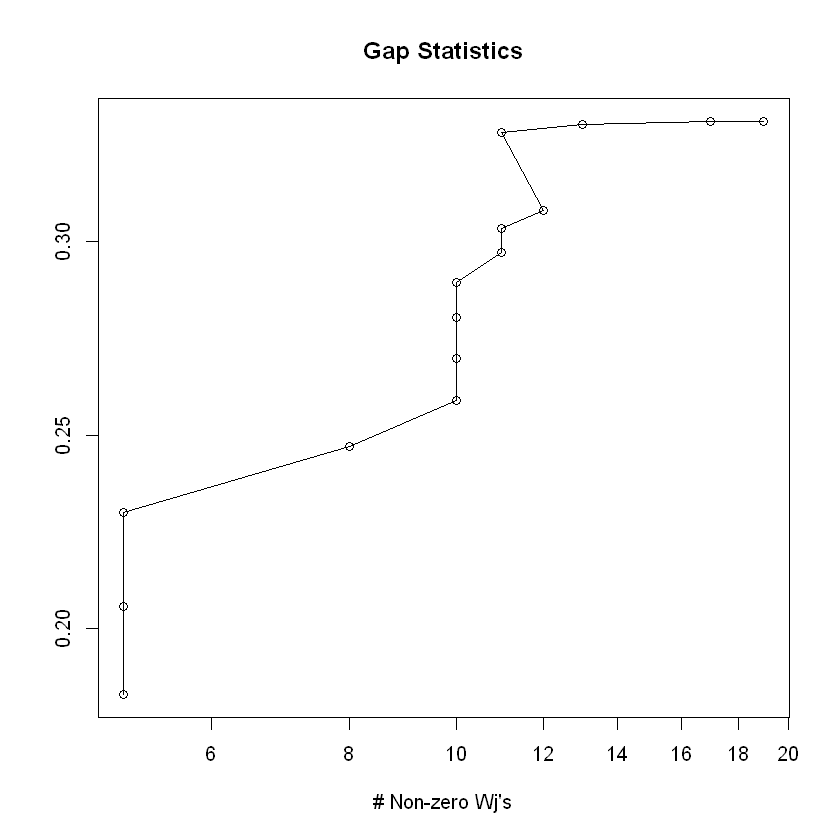

In [9]:
plot(km.perm)

In [10]:
l1 = km.perm$bestw
print(paste0("Best L1 upper bound is: ", l1))

[1] "Best L1 upper bound is: 3.13877880032998"


## Metrics relevancy <a class="anchor" id="rskc_metrics_relevancy"></a>

In [11]:
rskc_out = RSKC(df, global_k_value, 0.1, L1 = l1, nstart = 200,
        silent=TRUE, scaling = FALSE, correlation = FALSE)
cat(paste0("L1 value: ", l1,"\n"))
cat(names(rskc_out$weights)[1], ": ", rskc_out$weights[1],"\n")
cat(names(rskc_out$weights)[2], ": ", rskc_out$weights[2],"\n")
cat(names(rskc_out$weights)[3], ": ", rskc_out$weights[3],"\n")
cat("---\n")

L1 value: 3.13877880032998
ANOnto :  6.611874e-05 
AROnto :  0.01378815 
CBOOnto :  0.0001375295 
---


In [22]:
rskc_out


Input: 
#obs= 80  #feature= 19 
L1= 3.138779  alpha= 0.1

Result:
wbss: 11403.05
trimmed cases: 3 5 13 41 59 67 71 73 2 21
#non-zero weights: 19 
 4 clusters of sizes 29, 17, 26, 8 
Cluster labels: 3 3 2 3 2 4 3 3 3 2 4 4 2 4 1 3 4 3 2 3 3 3 4 1 4 3 2 4 3 3 4 3 4 4 3 3 2 4 3 1 2 3 2 3 3 1 4 4 3 1 3 1 3 2 4 4 2 4 2 3 4 4 3 3 4 1 2 3 2 4 2 4 2 4 3 2 4 4 1 4 

### Trimmed cases <a class="anchor" id="rskc_trimmed"></a>

- oE:
Indices of the cases trimmed in squared Euclidean distances.

- oW:	
Indices of the cases trimmed in weighted squared Euclidean distances. If L1 =NULL, then oW are the cases trimmed in the Euclidean distance, because all the features have the same weights, i.e., 1's.

In [13]:
union_vector = c(rskc_out$oE,rskc_out$oW)
union_vector_unique = unique(union_vector)
union_vector_unique = sort(union_vector_unique)

print(paste0("Trimmed cases from input dataframe: "))
union_vector_unique

[1] "Trimmed cases from input dataframe: "


[1]  2  3  5 13 21 41 59 67 71 73

In [14]:
options(scipen=10)

In [15]:
columns = c('metric', 'weight')
rskc_df = data.frame(matrix(ncol = length(columns), nrow = length(rskc_out$weights)))
colnames(rskc_df) = columns
rskc_df['metric'] = names(rskc_out$weights)
rskc_df['weight'] = rskc_out$weights
rskc_df

metric,weight
ANOnto,0.000066118736
AROnto,0.013788146264
CBOOnto,0.000137529515
CBOOnto2,0.000137529515
CROnto,0.000000522733
DITOnto,0.141330643451
INROnto,0.000112816999
LCOMOnto,0.027539665939
NACOnto,0.000141456181
NOCOnto,0.005176250933


### Relevancy table <a class="anchor" id="rskc_relevancy_table"></a>

In [16]:
rskc_df_sorted = rskc_df[order(rskc_df$weight, decreasing = TRUE), ]
rskc_df_sorted

,metric,weight
18,WMCOnto,0.989440143199
6,DITOnto,0.141330643451
8,LCOMOnto,0.027539665939
2,AROnto,0.013788146264
19,WMCOnto2,0.007622828650
10,NOCOnto,0.005176250933
17,TMOnto2,0.000382020897
14,RFCOnto,0.000327351767
11,NOMOnto,0.000217580348
12,POnto,0.000155537592


# References <a class="anchor" id="references"></a>

<a id="1">[1]</a>
Kondo, Y., Salibian-Barrera, M., & Zamar, R. (2016). RSKC: An R Package for a Robust and Sparse K-Means Clustering Algorithm. Journal of Statistical Software, 72(5), 1–26. https://doi.org/10.18637/jss.v072.i05

<a id="2">[2]</a>
Witten, D. M., & Tibshirani, R. (2010). A framework for feature selection in clustering. Journal of the American Statistical Association, 105(490), 713–726. https://doi.org/10.1198/jasa.2010.tm09415

<a id="3">[3]</a>
Robert Tibshirani, & Guenther Walther (2005). Cluster Validation by Prediction Strength. Journal of Computational and Graphical Statistics, 14(3), 511-528. https://doi.org/10.1198/106186005X59243

<a id="4">[4]</a>
Gordaliza, A. (1991). On the breakdown point of multivariate location estimators based on trimming procedures. Statistics & Probability Letters, 11(5), 387-394. https://doi.org/10.1016/0167-7152(91)90186-U

<a id="5">[5]</a>
Tibshirani, R., Walther, G., & Hastie, T. (2001). Estimating the number of clusters in a data set via the gap statistic. Journal of the Royal Statistical Society: Series B (Statistical Methodology), 63(2), 411-423. https://doi.org/10.1111/1467-9868.00293

<a id="6">[6]</a>
Witten, D. M., & Tibshirani, R. (2010). sparcl: Perform Sparse Hierarchical Clustering and Sparse K-Means Clustering. R package. https://CRAN.R-project.org/package=sparcl

<a id="7">[7]</a>
José Antonio Bernabé-Díaz, Manuel Franco, Juana-María Vivo, Manuel Quesada-Martínez, & Jesualdo T. Fernández-Breis (2022). An automated process for supporting decisions in clustering-based data analysis. Computer Methods and Programs in Biomedicine, 219, 106765. https://doi.org/10.1016/j.cmpb.2022.106765


In [ ]:
# TODO: (1) If all good, integrate into evaluomeR, (2)  choose use case, compare if optimal K values can be found even by removing "not important" metrics